### 4.3 A Gaussian model of height

In [1]:
import pandas as pd
import numpy as np
import arviz as az  #ArviZ: Exploratory analysis of Bayesian models
import matplotlib.pyplot as plt
from scipy.stats import norm, uniform
import seaborn as sns
import pymc3 as pm

##### load the data and create a subset (code 4.10)

In [2]:
df = pd.read_csv('../Data/Howell1.csv', sep=';', header=0)
df.head()
df2 = df[df.age >=18]

In [3]:
#df2.sort_values('age').head()

##### kde of height

Text(0.5, 0, 'Height')

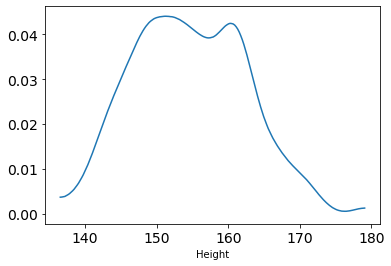

In [4]:
az.plot_kde(df2.height)
plt.xlabel('Height')

##### code 4.11

In [5]:
x = np.linspace(100, 250, num=1000)
y = norm.pdf(x, loc=178, scale=20)

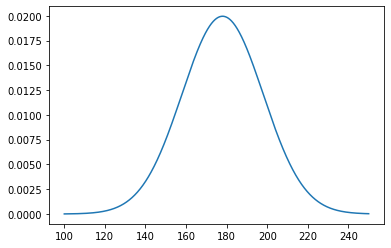

In [6]:
plt.plot(x, y)
plt.show()

##### code 4.12

In [7]:
x = np.linspace(-10, 60, num=100)
y = uniform.pdf(x, loc=0, scale=50)

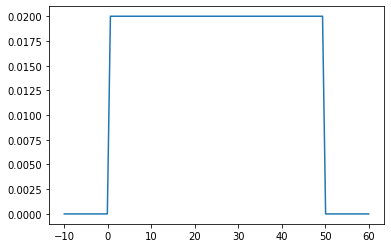

In [8]:
plt.plot(x, y)
plt.show()

##### code 4.13

In [9]:
sample_mu = norm.rvs(loc=178, scale=20, size=int(1e4), random_state=110)
sample_sigma = uniform.rvs(loc=0, scale=50, size=int(1e4), random_state=110)

In [10]:
prior_h = norm.rvs(loc=sample_mu, scale=sample_sigma, size=int(1e4), random_state=110)
# note: It is not clear whether the code above is accurate; that is, it is not clear to me what happens afer passing a  
# vector for loc and a vector for scale. 

Text(0.5, 0, 'prior_h')

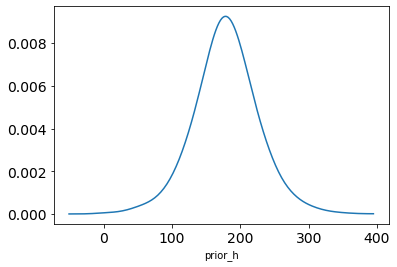

In [11]:
az.plot_kde(prior_h)
plt.xlabel('prior_h')


##### code 4.14. 
##### notice that here, we use log probabilities, instead of probabilities
##### 

In [12]:
#mu_list = np.linspace(140, 160, num=200)
#sigma_list = np.linspace(4, 9, num=200)
#mu_axis, sigma_axis = np.meshgrid(mu_list, sigma_list)
# it seems that np.mgrid is preferred over np.meshgrid, see http://louistiao.me/posts/numpy-mgrid-vs-meshgrid/#id2

In [13]:
post = np.mgrid[140:160:200j, 4:9:200j].reshape(2, -1).T #notice that we need to use mgrid[], instead of ()

In [14]:
log_likelihood = [np.sum(norm.logpdf(df2.height, loc=post[:,0][i], scale=post[:,1][i])) for i in range(len(post))]
log_posterior = log_likelihood + norm.logpdf(post[:, 0], loc=178, scale=20) + uniform.logpdf(post[:, 1], loc=0, scale=50)
posterior = np.exp(log_posterior - max(log_posterior))

In [15]:
posterior_df = pd.DataFrame([post[:, 0],post[:, 1], posterior]).T
posterior_df.columns = ["mu", 'sigma', 'posterior']
posterior_df.head()

,mu,sigma,posterior
0,140.0,4.000000,0.0
1,140.0,4.025126,0.0
2,140.0,4.050251,0.0
3,140.0,4.075377,0.0
4,140.0,4.100503,0.0


##### ! I skip the contour map here (i.e., 4.15, and 4.16). 

##### code 4.17~4.18

In [16]:
sample_rows = np.random.choice(np.arange(len(posterior)), size=int(1e4), replace=True, p=posterior/posterior.sum())

In [17]:
sample_mu = posterior_df.iloc[sample_rows, 0]
sample_sigma = posterior_df.iloc[sample_rows, 1]

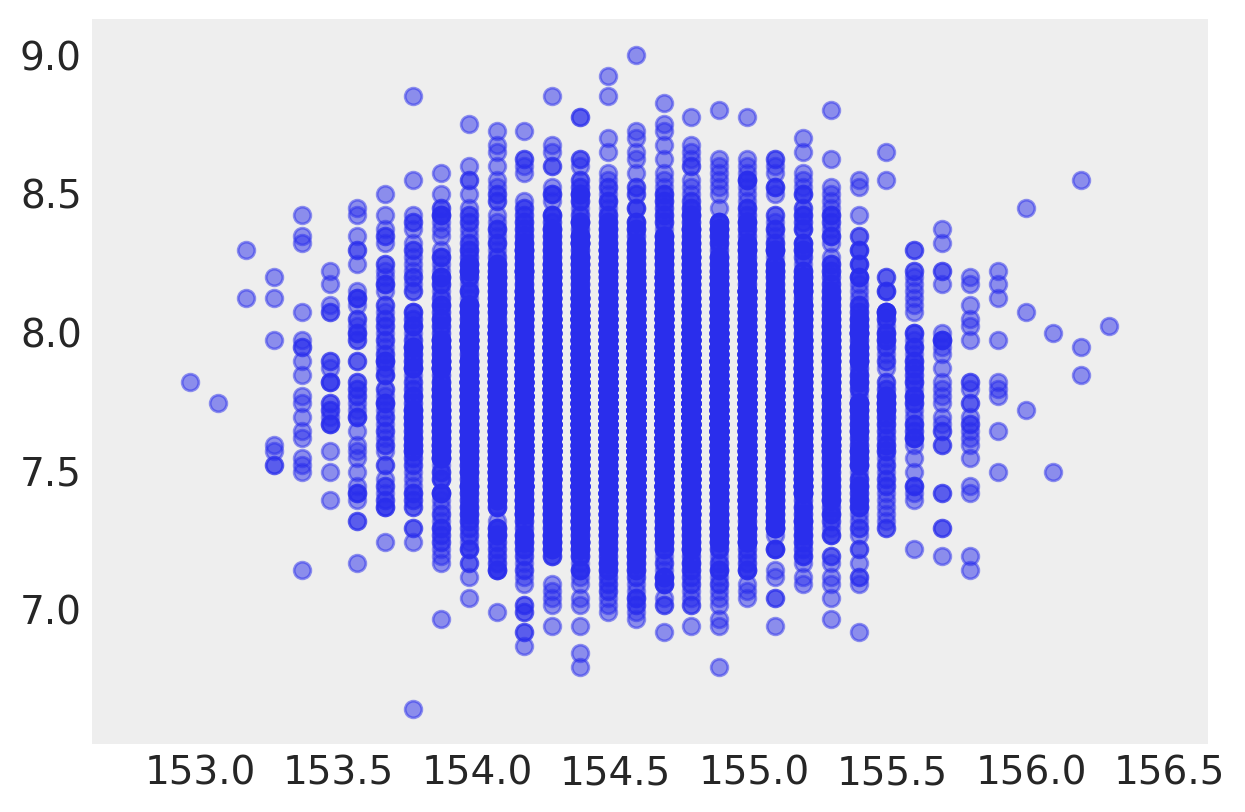

In [18]:
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')
plt.scatter(sample_mu, sample_sigma, marker='o', alpha=0.5)
plt.axis('equal')
plt.grid(False)

### use pymc3 to fit the model (4.3.5)

In [19]:
with pm.Model() as model: # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    mu = pm.Normal('mu', mu=178, sigma=20)
    sigma = pm.Uniform('sigma', lower=0, upper=50)

    # Define likelihood
    likelihood = pm.Normal('height', mu=mu,
                        sigma=sigma, observed=df2.height)

    # Inference!
    trace = pm.sample(3000, cores=2) # draw 3000 posterior samples using NUTS sampling

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, mu]
Sampling 2 chains, 0 divergences: 100%|██████████| 7000/7000 [00:03<00:00, 1856.16draws/s]


##### code 4.26~4.27 maximum a posteriori

In [20]:
map_estimate = pm.find_MAP(model=model)
map_estimate


logp = -1,235.2, ||grad|| = 11.697: 100%|██████████| 19/19 [00:00<00:00, 3277.47it/s]  


{'mu': array(154.60702358),
 'sigma_interval__': array(-1.69876478),
 'sigma': array(7.73133303)}

##### code 4.29 a more informative prior

In [21]:
with pm.Model() as model_1: # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    mu = pm.Normal('mu', mu=178, sigma=0.1)
    sigma = pm.Uniform('sigma', lower=0, upper=50)

    # Define likelihood
    likelihood = pm.Normal('height', mu=mu,
                        sigma=sigma, observed=df2.height)

    # Inference!
    trace = pm.sample(3000, cores=2)

map_estimate_1 = pm.find_MAP(model=model_1)
map_estimate_1

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, mu]
Sampling 2 chains, 0 divergences: 100%|██████████| 7000/7000 [00:03<00:00, 1862.72draws/s]
logp = -1,630.1, ||grad|| = 14.075: 100%|██████████| 7/7 [00:00<00:00, 3307.81it/s]


{'mu': array(177.86375428),
 'sigma_interval__': array(-0.03860064),
 'sigma': array(24.51755186)}

##### notice that az.summary() is very useful!

In [22]:
az.summary(trace, credible_interval=.89).round(2)

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,177.87,0.10,177.70,178.03,0.00,0.00,5434.0,5434.0,5420.0,4219.0,1.0
sigma,24.60,0.96,23.08,26.15,0.01,0.01,5217.0,5165.0,5278.0,3238.0,1.0


##### 4.3.6 sampling from map fit
##### code 4.30

In [23]:
df_trace = pm.backends.tracetab.trace_to_dataframe(trace)  #notice that .trace_to_dataframe() method is not clearly mentioned in the documentation, yet it works
df_trace.cov()

,mu,sigma
mu,0.010402,0.009870
sigma,0.009870,0.929537


#### 4.4 Adding a predictor

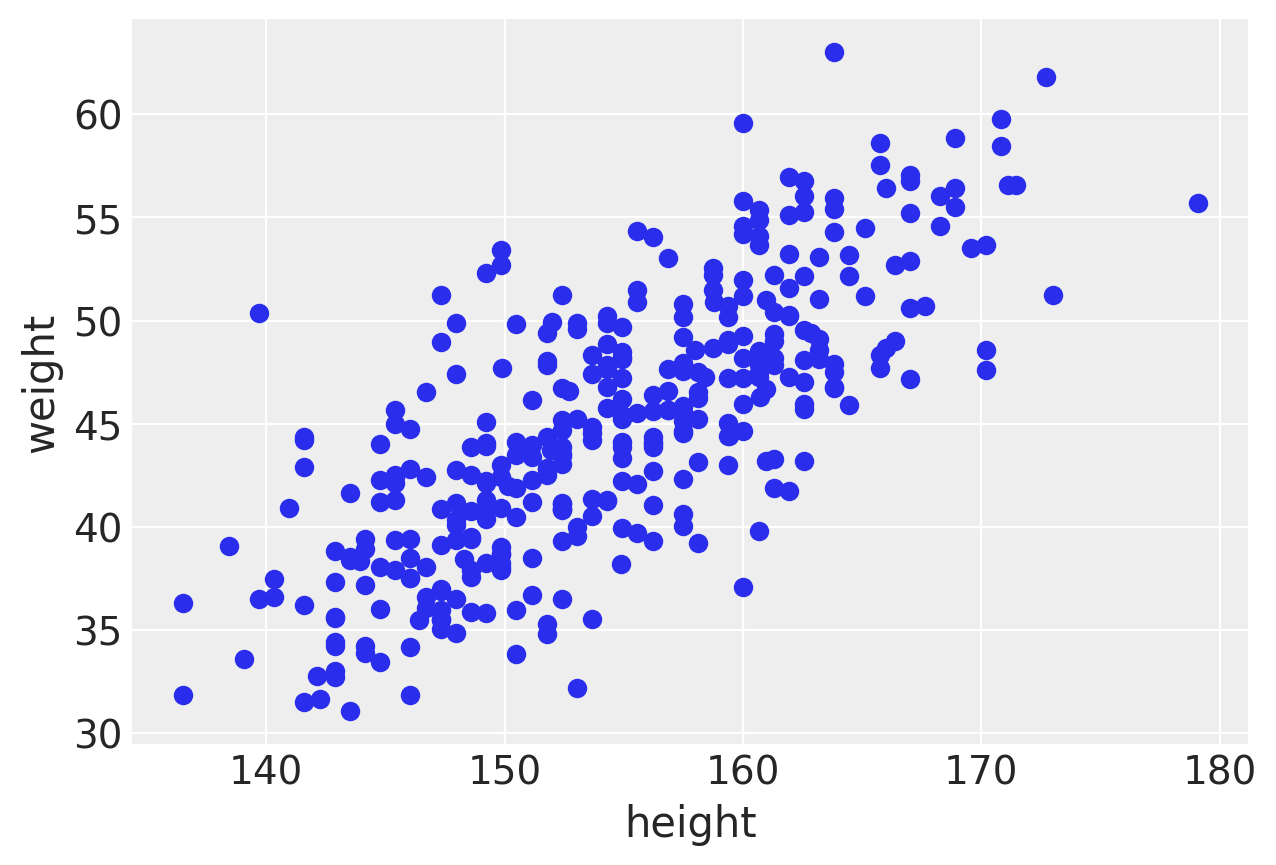

In [24]:
plt.scatter(df2.height, df2.weight)
plt.xlabel('height')
plt.ylabel('weight')
plt.show()

##### code 4.38

In [25]:
with pm.Model() as model_438: # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    alpha = pm.Normal('alpha', mu=178, sigma=100)
    beta = pm.Normal('beta', mu=0, sigma=10)
    sigma = pm.Uniform('sigma', lower=0, upper=50)

    mu = alpha + beta * df2.weight
    # Define likelihood
    likelihood = pm.Normal('height', mu=mu,
                        sigma=sigma, observed=df2.height)

    # Inference!
    trace = pm.sample(3000) # draw 3000 posterior samples using NUTS sampling



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
Sampling 4 chains, 0 divergences: 100%|██████████| 14000/14000 [00:12<00:00, 1156.69draws/s]
The acceptance probability does not match the target. It is 0.9076545522667839, but should be close to 0.8. Try to increase the number of tuning steps.


/Users/zhengguo/.pyenv/versions/3.8.0/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/zhengguo/.pyenv/versions/3.8.0/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/zhengguo/.pyenv/versions/3.8.0/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12ee80fd0>,
      dtype=object)

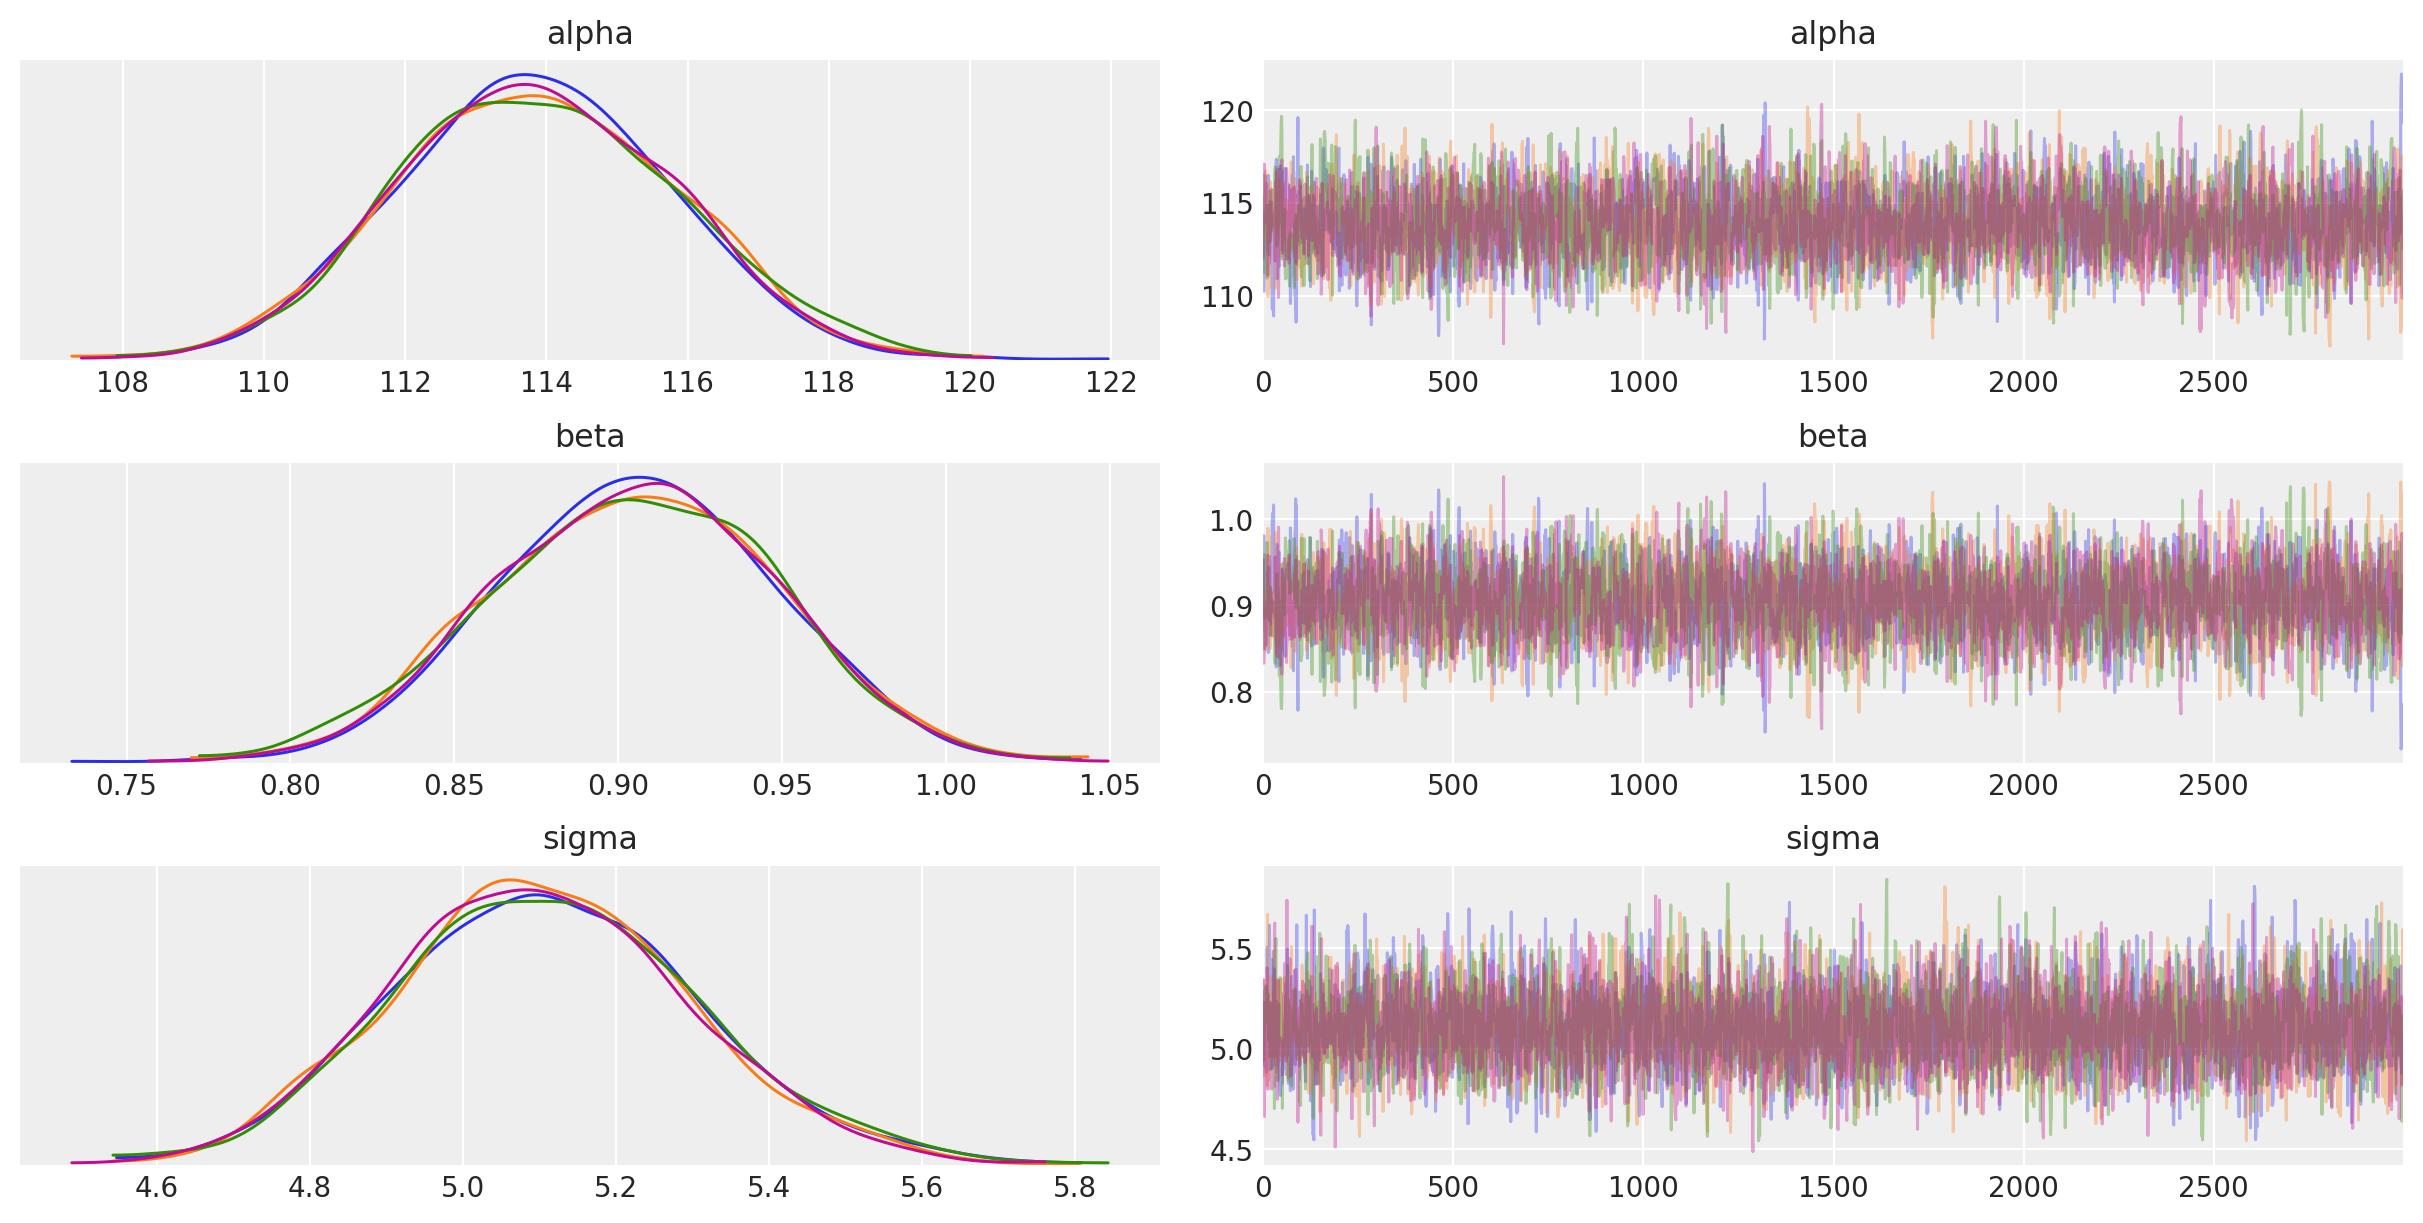

In [26]:
pm.traceplot(trace)

In [27]:
az.summary(trace, credible_interval=.89)


,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,113.872,1.937,110.897,117.008,0.031,0.022,4005.0,4000.0,4008.0,4606.0,1.0
beta,0.905,0.043,0.839,0.974,0.001,0.000,3993.0,3993.0,3997.0,4694.0,1.0
sigma,5.107,0.194,4.786,5.404,0.003,0.002,5221.0,5185.0,5277.0,4976.0,1.0


In [28]:
trace_df = pm.trace_to_dataframe(trace)
trace_df.corr().round(2)
#notice that alpha and beta are highly negatively correlated, which is not good (in more complex models). 

,alpha,beta,sigma
alpha,1.00,-0.99,0.03
beta,-0.99,1.00,-0.03
sigma,0.03,-0.03,1.00


##### de-mean 

In [29]:
df2.weight = df2.weight - df2.weight.mean()


/Users/zhengguo/.pyenv/versions/3.8.0/lib/python3.8/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
Sampling 4 chains, 0 divergences: 100%|██████████| 14000/14000 [00:05<00:00, 2736.60draws/s]
/Users/zhengguo/.pyenv/versions/3.8.0/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/zhengguo/.pyenv/versions/3.8.0/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/zhengguo/.pyenv/versions/3.8.0/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(


,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,154.595,0.277,154.146,155.028,0.002,0.002,14770.0,14767.0,14719.0,9063.0,1.0
beta,0.905,0.042,0.837,0.971,0.000,0.000,14620.0,14600.0,14610.0,8994.0,1.0
sigma,5.101,0.196,4.797,5.419,0.002,0.001,15080.0,15069.0,15030.0,8571.0,1.0


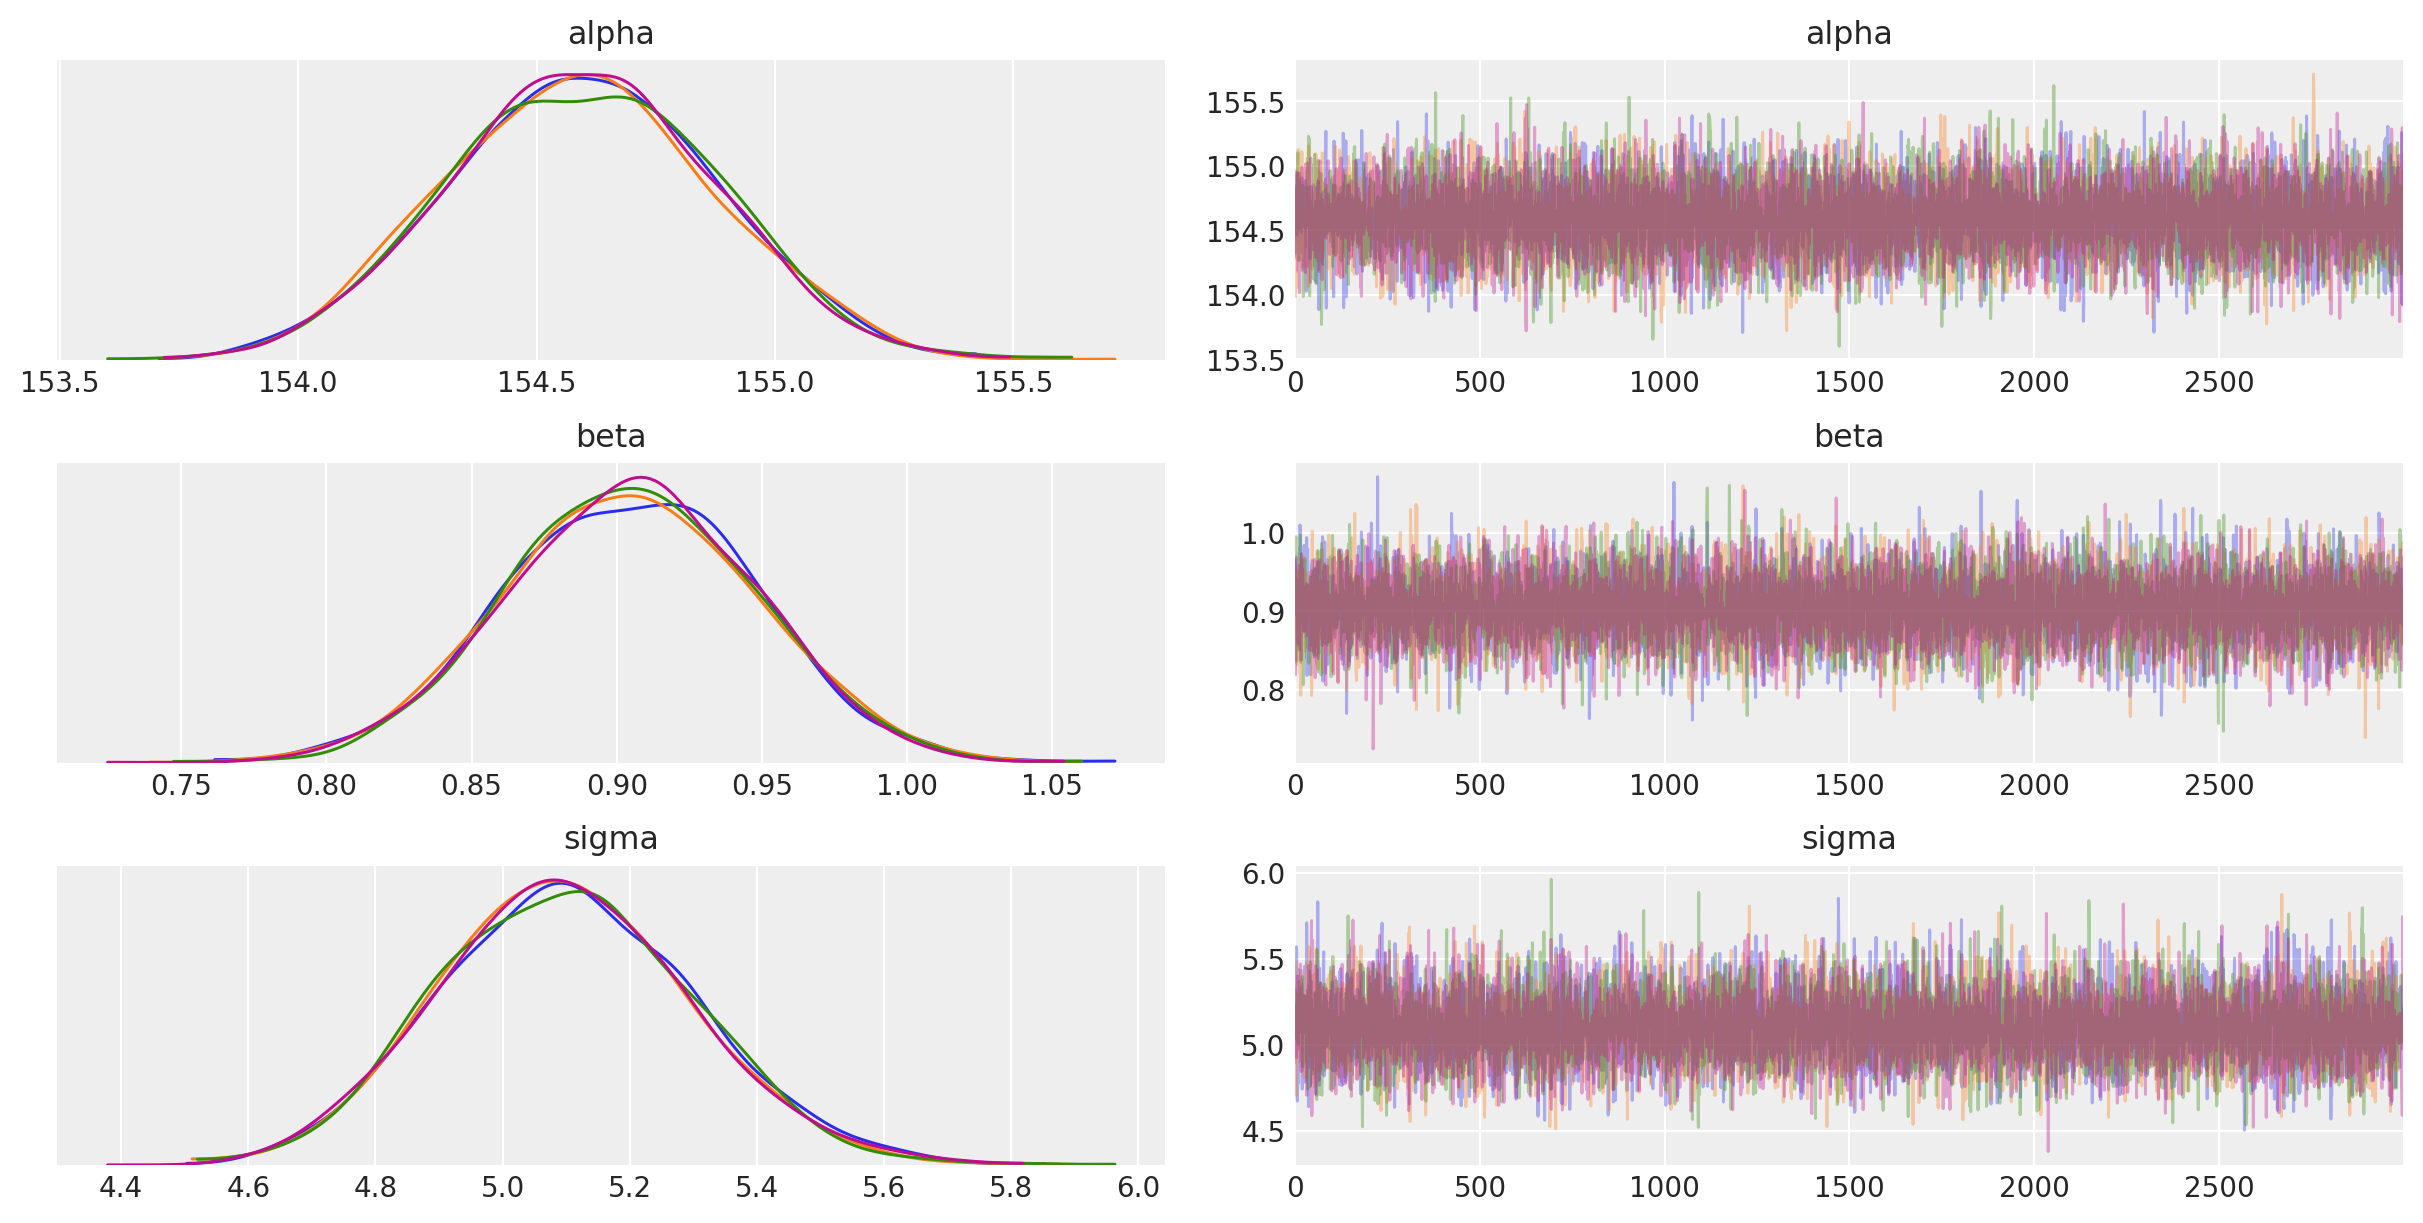

In [30]:
with pm.Model() as model_443: # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    alpha = pm.Normal('alpha', mu=178, sigma=100)
    beta = pm.Normal('beta', mu=0, sigma=10)
    sigma = pm.Uniform('sigma', lower=0, upper=50)

    mu = alpha + beta * df2.weight
    # Define likelihood
    likelihood = pm.Normal('height', mu=mu,
                        sigma=sigma, observed=df2.height)

    # Inference!
    trace_443 = pm.sample(3000) # draw 3000 posterior samples using NUTS sampling

pm.traceplot(trace_443)

az.summary(trace_443, credible_interval=.89)


In [31]:
trace_df = pm.trace_to_dataframe(trace_443)
trace_df.corr().round(2)

#notice that predictor weight is de-meaned, as a result, the estimated alpha and beta are not correlated anymore, 
# this is because of the de-mean: now alpha means that when predictor = 0, which happens to be the average weight. 

,alpha,beta,sigma
alpha,1.00,-0.01,-0.04
beta,-0.01,1.00,-0.00
sigma,-0.04,-0.00,1.00


In [32]:
alpha_hat = trace_443['alpha'].mean()  #notice that this mean is just the mean in the table
beta_hat = trace_443['beta'].mean()

In [33]:
print(alpha_hat, beta_hat)

154.59511656764533 0.9049600054758027


##### code 4.45

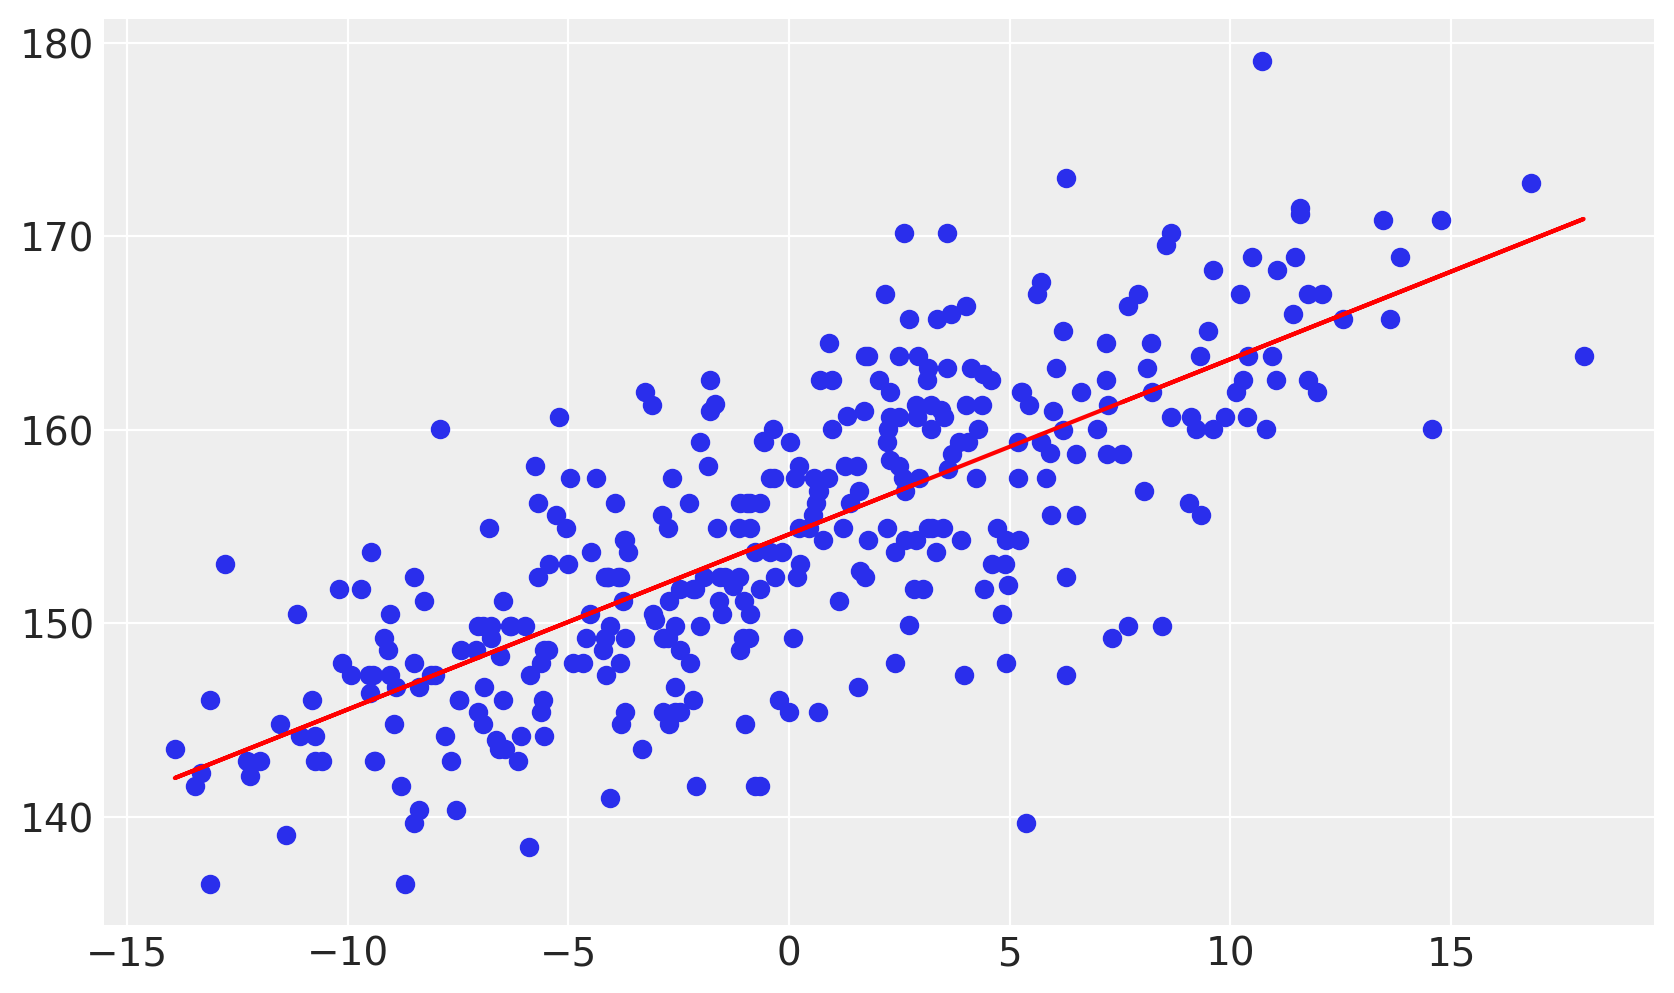

In [34]:
fig, bayesian = plt.subplots(figsize=(10, 6))
bayesian.scatter(df2.weight, df2.height)
bayesian.plot(df2.weight, alpha_hat + beta_hat * df2.weight, color='red')

#### code 4.48 ~


In [35]:
N = 10
df2_N = df2.iloc[:10, :]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
Sampling 4 chains, 0 divergences: 100%|██████████| 14000/14000 [00:05<00:00, 2653.33draws/s]
/Users/zhengguo/.pyenv/versions/3.8.0/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/zhengguo/.pyenv/versions/3.8.0/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/zhengguo/.pyenv/versions/3.8.0/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(


,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,151.892,1.937,148.785,154.714,0.022,0.016,7588.0,7588.0,8019.0,6309.0,1.0
beta,0.944,0.193,0.646,1.245,0.002,0.002,8062.0,7540.0,8464.0,6191.0,1.0
sigma,5.815,1.862,3.239,8.105,0.025,0.018,5363.0,5133.0,6100.0,5698.0,1.0


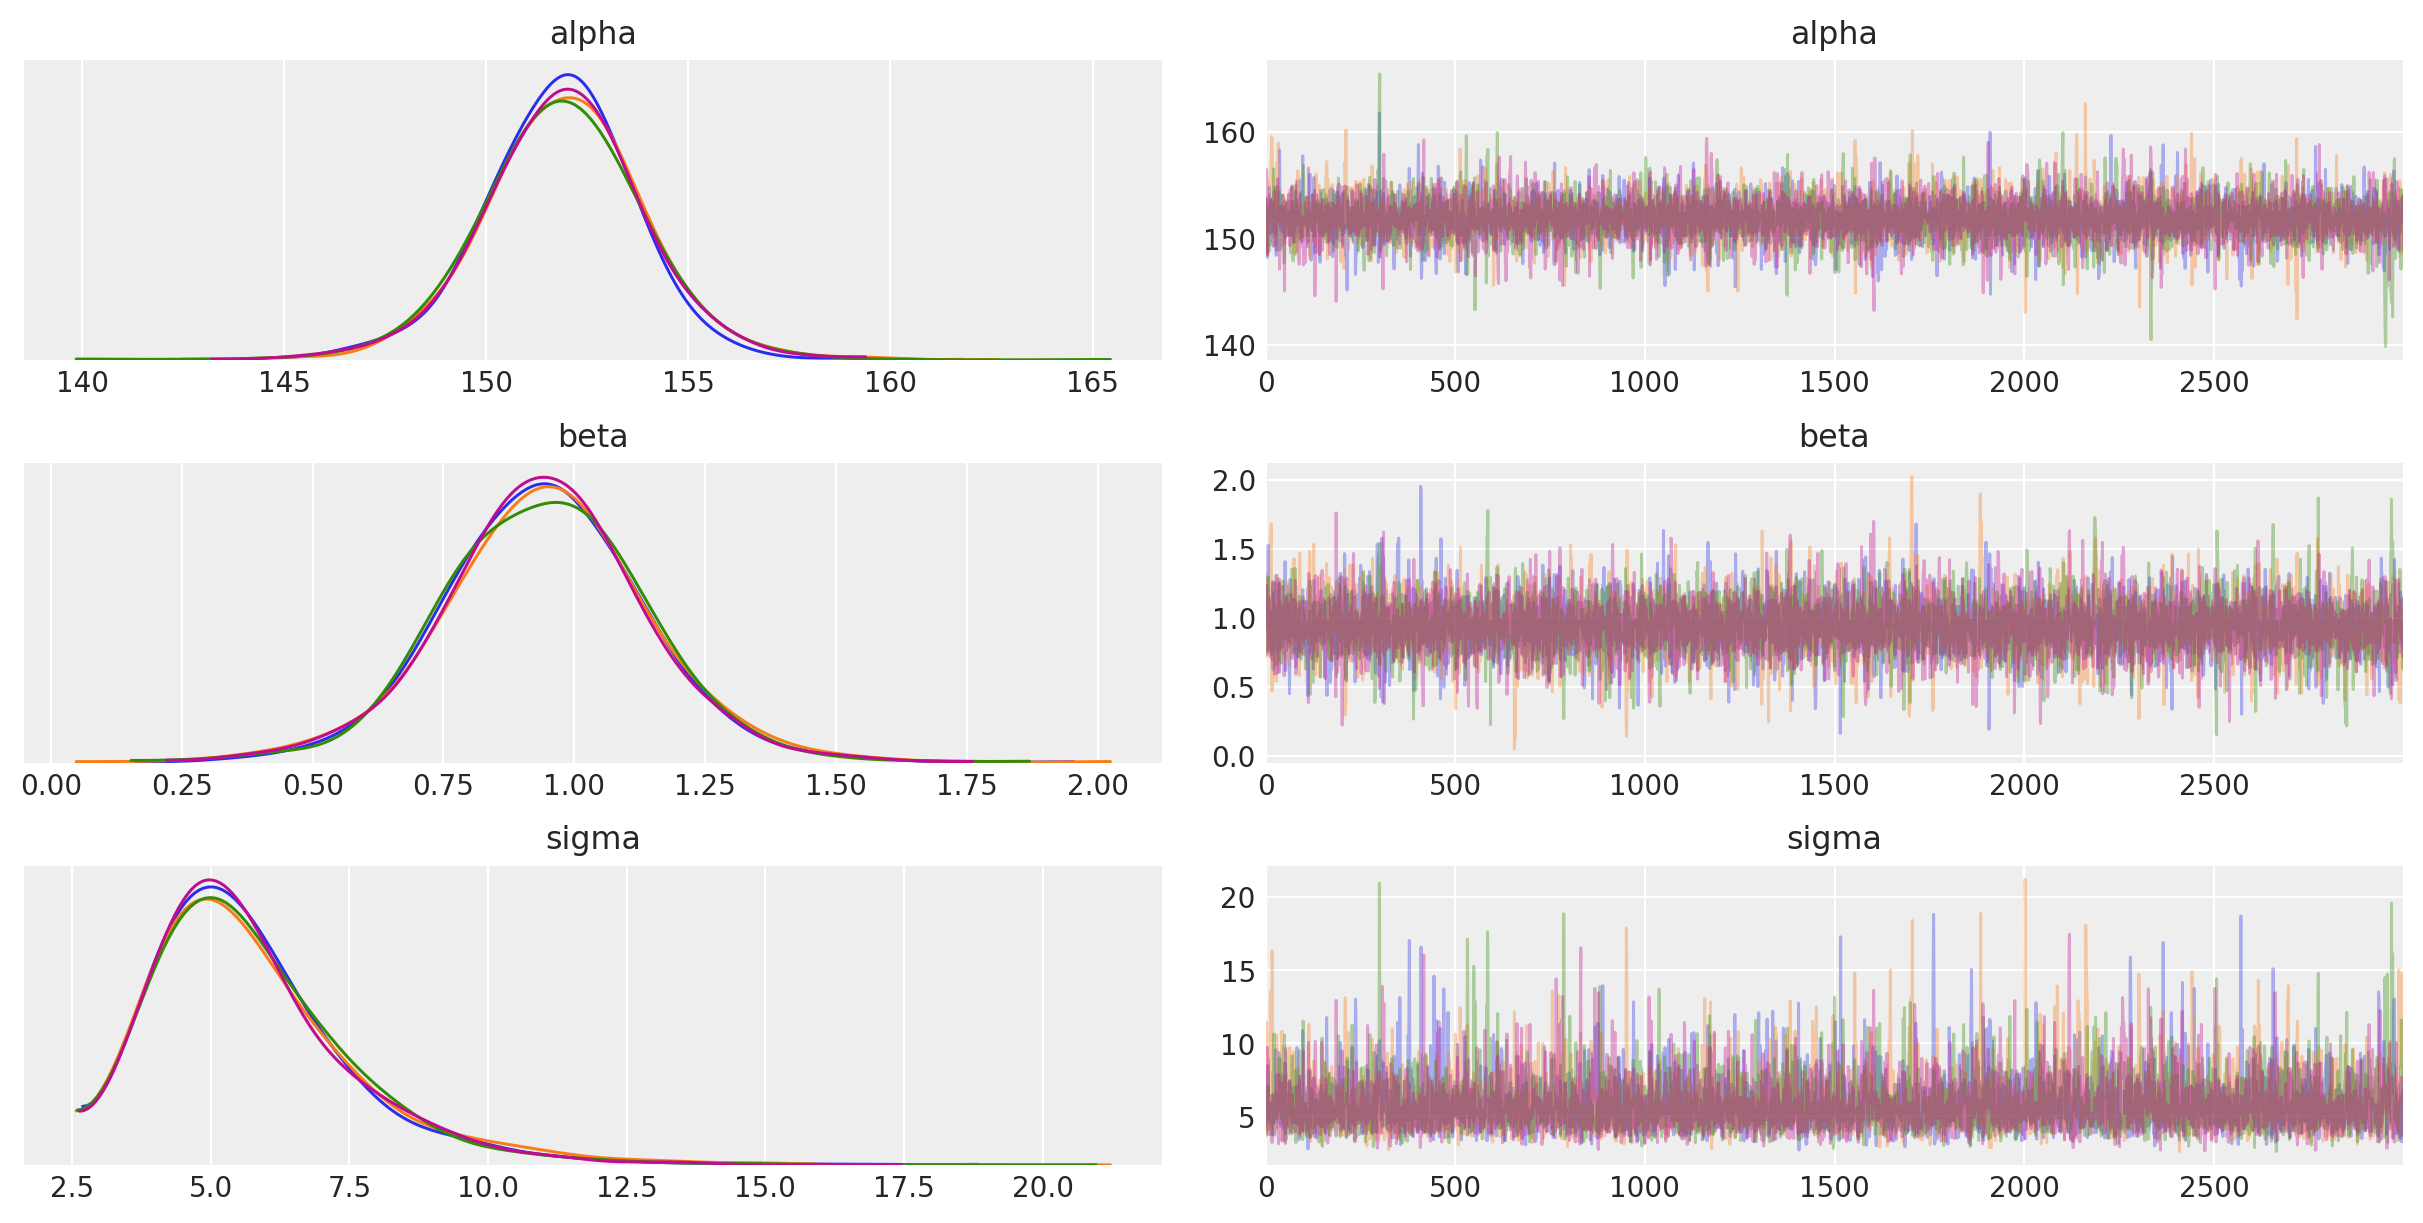

In [36]:
with pm.Model() as model_N10: # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    alpha = pm.Normal('alpha', mu=178, sigma=100)
    beta = pm.Normal('beta', mu=0, sigma=10)
    sigma = pm.Uniform('sigma', lower=0, upper=50)

    mu = alpha + beta * df2_N.weight
    # Define likelihood
    likelihood = pm.Normal('height', mu=mu,
                        sigma=sigma, observed=df2_N.height)

    # Inference!
    trace_N10 = pm.sample(3000) # draw 3000 posterior samples using NUTS sampling

pm.traceplot(trace_N10)

az.summary(trace_N10, credible_interval=.89)

In [37]:
alpha_hat = trace_N10['alpha'].mean()  #notice that this mean is just the mean in the table
beta_hat = trace_N10['beta'].mean()

In [38]:
sample_index = np.random.choice(np.arange(0,3000), size=20, replace=False)
sampled_posterior = pm.trace_to_dataframe(trace_N10)
sampled_posterior = sampled_posterior.iloc[sample_index, :] #we actually draw 20 samples from the first chain!

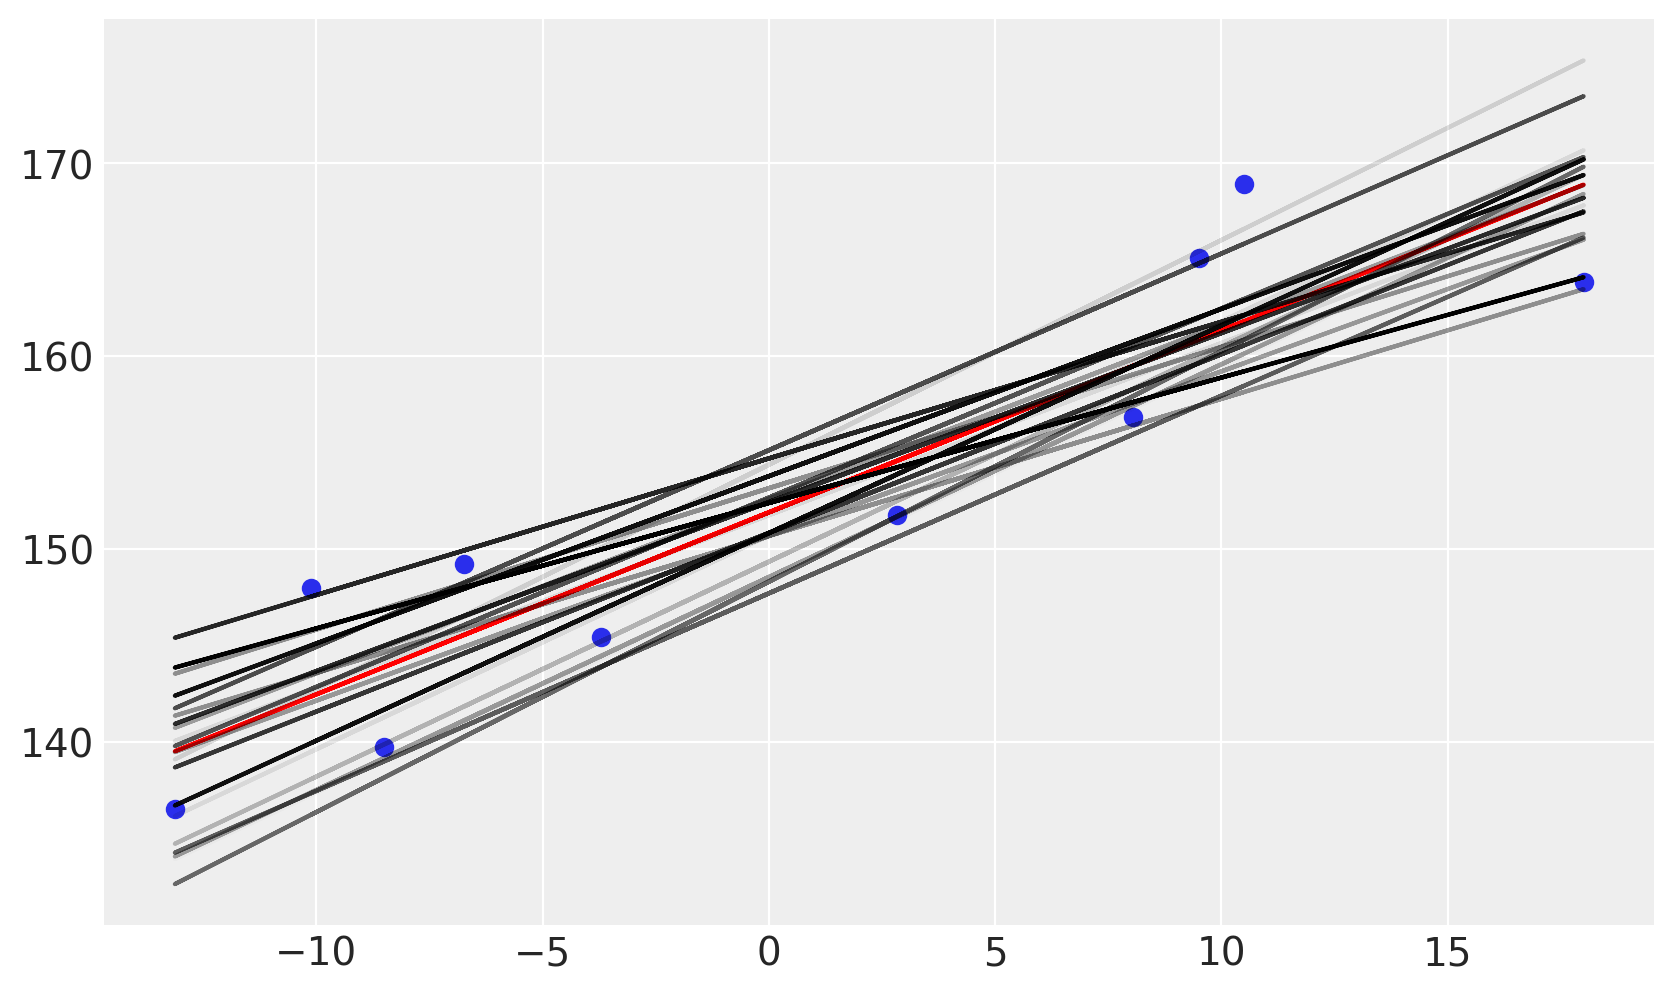

In [39]:
fig, bayesian = plt.subplots(figsize=(10, 6))
bayesian.scatter(df2_N.weight, df2_N.height)
bayesian.plot(df2_N.weight, alpha_hat + beta_hat * df2_N.weight, color='red')
for i in range(20):
    alpha_new = sampled_posterior.iloc[i, 0]
    beta_new = sampled_posterior.iloc[i, 1]
    sigma_new = sampled_posterior.iloc[i, 2]
    bayesian.plot(df2_N.weight, alpha_new + beta_new * df2_N.weight, color='black', alpha=sigma_new)

In [40]:
sampled_posterior.iloc[1,1]

1.076756184897019

##### 4.4.3.4 plotting regression intervals and contours

In [42]:
# let wight = 50
mu_at_50 = sampled_posterior['alpha'] + sampled_posterior['beta'] * 50  #recall that sampled_posterior is sampled from the posterior
mu_at_50

184     206.175815
625     204.654673
2822    190.129466
1002    197.164684
1273    193.367148
1633    208.073156
240     203.736318
442     196.376524
1954    205.073534
1591    212.601354
2852    198.946225
2823    196.256065
965     197.153168
2715    186.212275
2170    189.799089
2048    197.808616
2332    184.904655
2271    201.732886
1279    206.116897
2439    203.646957
dtype: float64

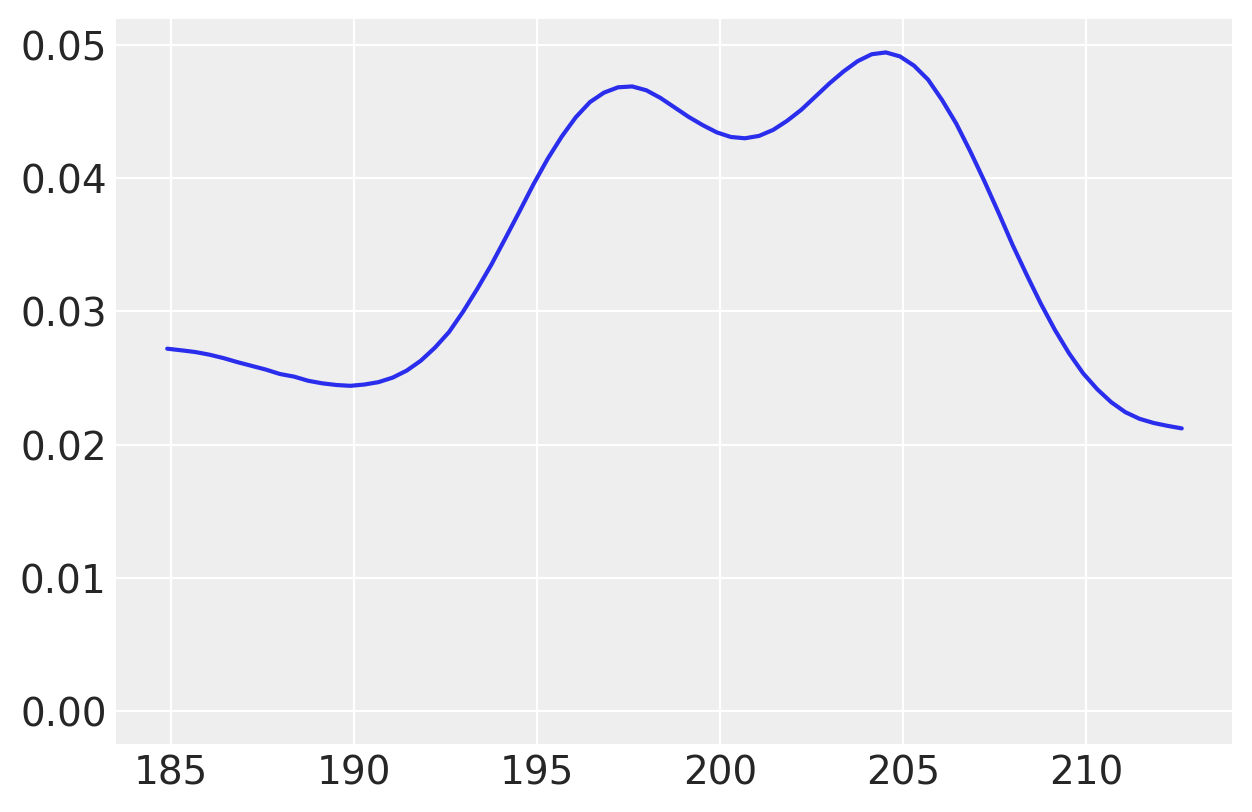

In [43]:
az.plot_kde(mu_at_50)

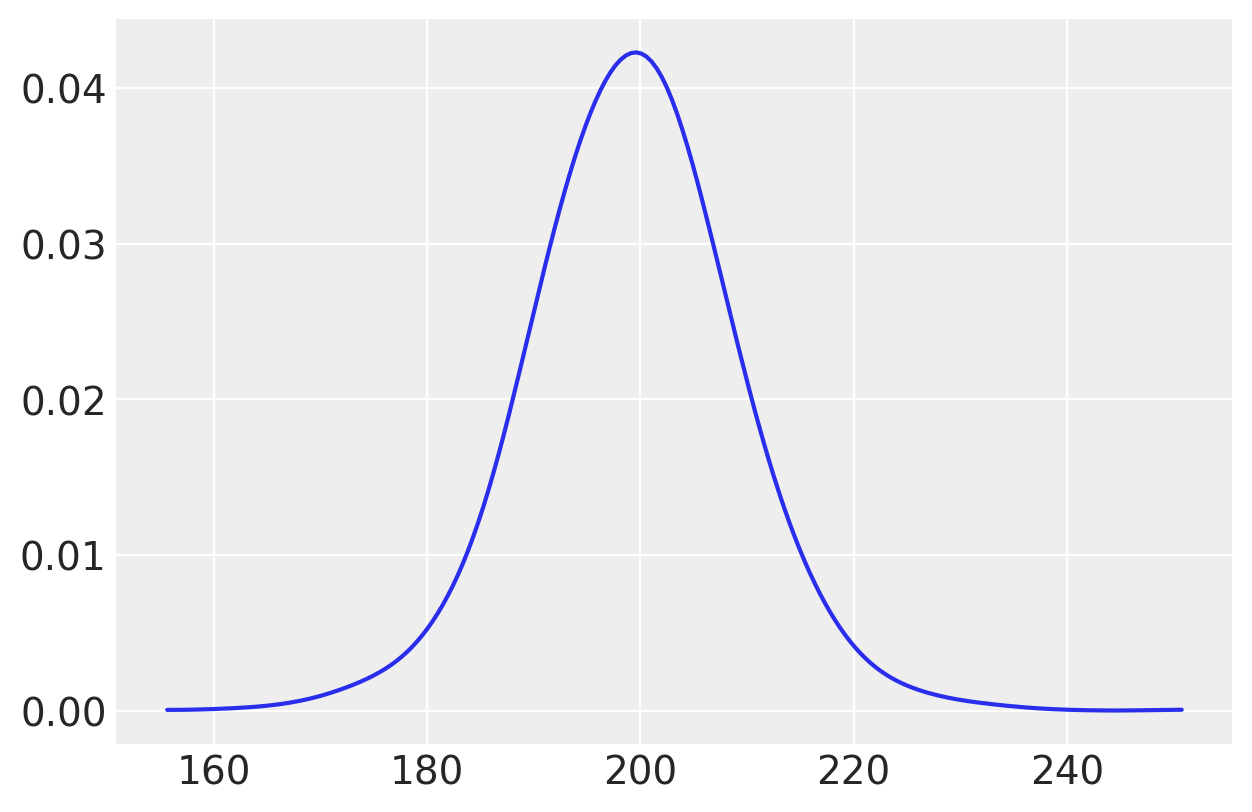

In [46]:
posterior_df = pm.trace_to_dataframe(trace_N10)
mu_at_50 = posterior_df['alpha'] + posterior_df['beta'] * 50  #recall that sampled_posterior is sampled from the posterior
az.plot_kde(mu_at_50)

In [52]:
#az.summary(trace_N10, credible_interval=0.89)
pm.stats.hpd(mu_at_50)

array([180.67314758, 217.41796836])

In [53]:
def hpd_per_weight(weight, posterior):
    """
    This computes the HPD for each element in weight (a vector), given the matrix of posterior
    """
    lo_list = []
    up_list = []
    for i in range(len(weight)):
        [lo, up] = pm.stats.hpd(posterior['alpha'] + posterior['beta'] * weight[i])
        lo_list.append(lo)
        up_list.append(up)
    
    return(lo_list, up_list)

In [54]:
weight_input = np.linspace(-15, 20, num=100)

In [56]:
lower, upper = hpd_per_weight(weight_input, posterior_df)

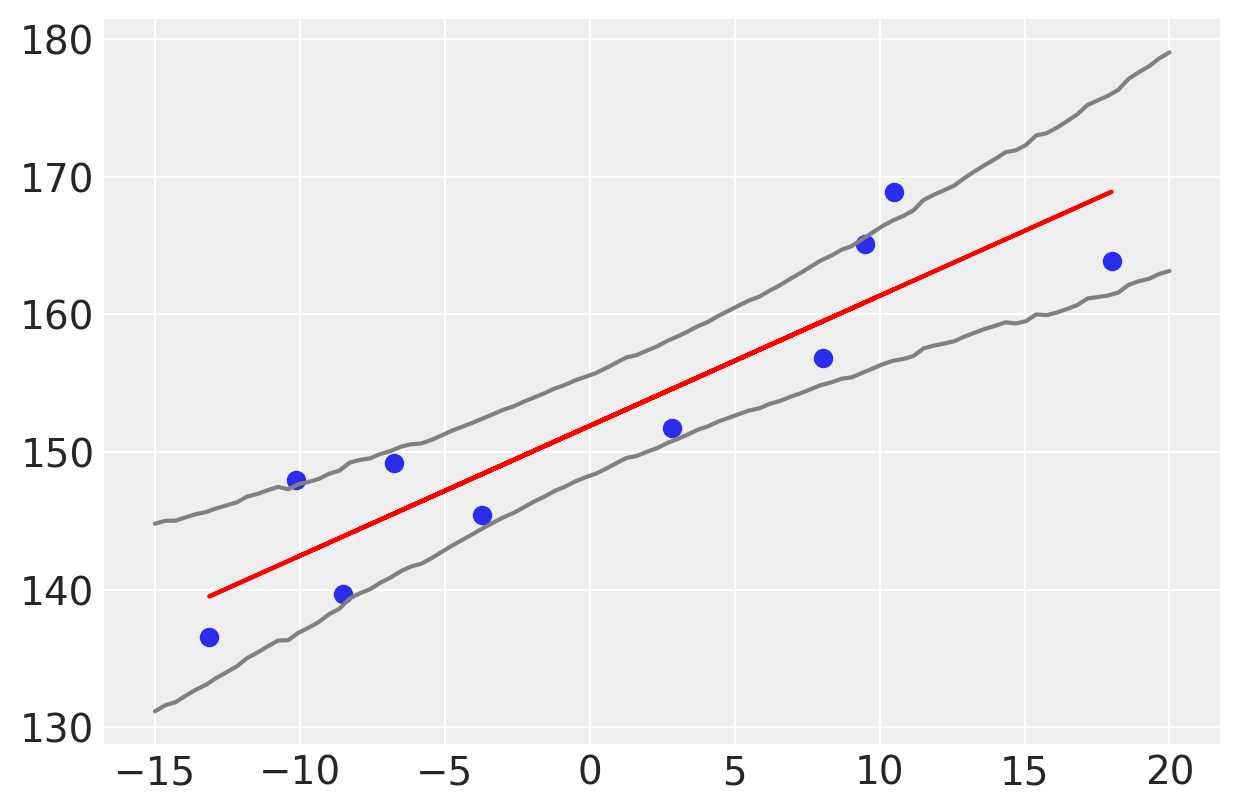

In [85]:
fig, bayesian = plt.subplots()
bayesian.scatter(df2_N.weight, df2_N.height)
bayesian.plot(df2_N.weight, alpha_hat + beta_hat * df2_N.weight, color='red')
bayesian.plot(weight_input, lower, color='gray')
bayesian.plot(weight_input, upper, color='gray')

##### notice that the az.plot_hpd() method below is way more elegant than my crude approach

In [86]:
mu_pred = np.zeros((len(weight_input), 12000))
for i, w in enumerate(weight_input):
    mu_pred[i] = posterior_df['alpha'] + posterior_df['beta'] * w
    
print(mu_pred)  #it's a 2d array

[[137.15291368 139.46349378 135.46084189 ... 142.68851057 140.15531467
  131.79510176]
 [137.47976397 139.79961454 135.79353351 ... 142.94308831 140.47136771
  132.19833655]
 [137.80661426 140.1357353  136.12622513 ... 143.19766605 140.78742076
  132.60157133]
 ...
 [168.85739188 172.06720764 167.731929   ... 167.38255147 170.81245995
  170.90887588]
 [169.18424218 172.4033284  168.06462062 ... 167.63712921 171.128513
  171.31211067]
 [169.51109247 172.73944916 168.39731224 ... 167.89170695 171.44456604
  171.71534545]]


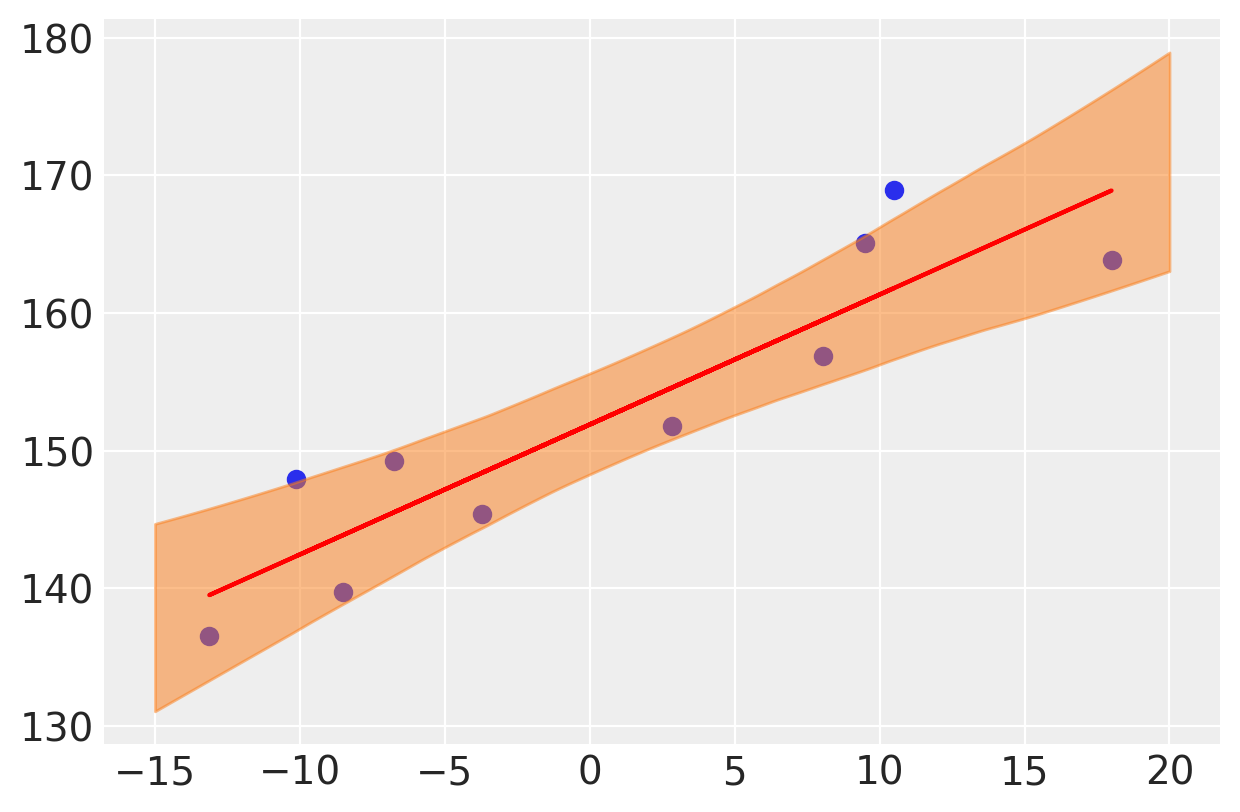

In [83]:
plt.scatter(df2_N.weight, df2_N.height)
plt.plot(df2_N.weight, alpha_hat + beta_hat * df2_N.weight, color='red')
az.plot_hpd(weight_input, mu_pred.T)  #notice that the 2D array mu_pred should be transposed first. 